# Generate Data for Chartbook

Brian Dew

@bd_econ

In [1]:
import sys
sys.path.append('../src')

import time

import uschartbook.config

from uschartbook.config import *
from uschartbook.utils import *

### Equities Index Data from Yahoo! Finance

In [2]:
ltdate = int(time.time())
indices = ['GSPC', 'IXIC', 'DJI', 'RUT']
raw = pd.DataFrame()
for s in indices:
    url = ('https://query1.finance.yahoo.com/v7/finance/download/'+
           f'%5E{s}?period1=599616000&period2={ltdate}&'+
           'interval=1d&events=history')
    df = pd.read_csv(url, index_col='Date', parse_dates=True)
    df = df[~df.index.duplicated(keep='last')]
    raw[f'{s}_close'] = df['Adj Close']
    raw[f'{s}_volume'] = df['Volume']
raw.to_csv(data_dir / 'equity_indices_raw.csv', index_label='date')

In [3]:
closecol = [f'{s}_close' for s in indices]
raw = pd.read_csv(data_dir / 'equity_indices_raw.csv', 
                  index_col='date', parse_dates=True)[closecol] / 1_000

rename = {f'{s}_close': f'{s}_MA' for s in indices}
(raw.join(raw.loc['2017':]
          .rolling(252).mean()
          .rename(rename, axis=1))
    .loc['2018':]
    .to_csv(data_dir / 'equity_indices_lt.csv', 
            index_label='date', float_format='%g'))
prmo = raw.resample('MS').mean().iloc[:-1]
prmo.index = prmo.index + pd.DateOffset(days=14)
data = pd.concat([prmo, raw.iloc[-1].to_frame().T])
res = data.rename({f'{s}_close': s for s in indices}, axis=1)
res.to_csv(data_dir / 'equity_indices.csv', index_label='date', 
            float_format='%g')
rename = {f'{s}_close': f'{s}_MA' for s in indices}
(raw.join(raw.loc['2017':]
          .rolling(252).mean()
          .rename(rename, axis=1))
    .loc['2018':]
    .to_csv(data_dir / 'equity_indices_lt.csv', 
            index_label='date', float_format='%g'))

# Percent change each year
ch = (raw.resample('Y').last().pct_change().iloc[-6:].multiply(100)
         .applymap('{:.1f}'.format))
ch.index = ch.index.year.astype('str').rename('')

yrago = ((raw.iloc[-252:].mean() * 1000)
             .rename('1-year moving average')
             .apply('{:,.0f}'.format))
ltval = ((raw.iloc[-1] * 1000)
             .rename(dtxt(raw.index[-1])['day2'])
             .apply('{:,.0f}'.format))
ch = pd.concat([ch, yrago.to_frame().T, ltval.to_frame().T])
names = {'GSPC_close': '\hspace{0.1mm} {\color{green!80!blue!90!black}\\textbf{---}} \ S\&P 500', 
         'IXIC_close': '\hspace{0.1mm} {\color{blue}\\textbf{---}} \ Nasdaq', 
         'DJI_close': '\hspace{0.1mm} {\color{red}\\textbf{---}} \ Dow 30', 
         'RUT_close': '\hspace{0.1mm} {\color{violet}\\textbf{---}} \ Russell 3000', }
ch = (ch.rename({'2023': '2023 YTD'}).iloc[::-1].T)
ch = (ch.reindex(list(names.keys())).rename(names))
ch.to_csv(data_dir / 'equities.tex', sep='&', lineterminator='\\\ ', quotechar=' ')

In [4]:
ltdt = dtxt(raw.index[-1])['day1']
sp00 = ((raw['GSPC_close'].iloc[-1] / raw.loc['2000', 'GSPC_close'].iloc[0]) - 1) * 100
sp00t = value_text(sp00)
sp18 = ((raw['GSPC_close'].iloc[-1] / raw.loc['2018', 'GSPC_close'].iloc[0]) - 1) * 100
sp18t = value_text(sp18)
text = (f'As of {ltdt}, the S\&P 500 has {sp00t} since 2000, and {sp18t} since 2018.')
write_txt(text_dir / 'eq_sp500.txt', text)  
print(text)
ns00 = ((raw['IXIC_close'].iloc[-1] / raw.loc['2000', 'IXIC_close'].iloc[0]) - 1) * 100
ns00t = value_text(ns00)
ns18 = ((raw['IXIC_close'].iloc[-1] / raw.loc['2018', 'IXIC_close'].iloc[0]) - 1) * 100
ns18t = value_text(ns18)
text = (f'The Nasdaq index {ns00t} since 2000, and {ns18t} since 2018.')
write_txt(text_dir / 'eq_nasdaq.txt', text)  
print(text)
dow00 = ((raw['DJI_close'].iloc[-1] / raw.loc['2000', 'DJI_close'].iloc[0]) - 1) * 100
dow00t = value_text(dow00)
dow18 = ((raw['DJI_close'].iloc[-1] / raw.loc['2018', 'DJI_close'].iloc[0]) - 1) * 100
dow18t = value_text(dow18)
text = (f'{dow00t} since 2000 and {dow18t} since 2018. ')
write_txt(text_dir / 'eq_dow.txt', text)  
print(text)
ru00 = ((raw['RUT_close'].iloc[-1] / raw.loc['2000', 'RUT_close'].iloc[0]) - 1) * 100
ru00t = value_text(ru00)
ru18 = ((raw['RUT_close'].iloc[-1] / raw.loc['2018', 'RUT_close'].iloc[0]) - 1) * 100
ru18t = value_text(ru18)
text = (f'Since 2000, the Russell 3000 has {ru00t}. Since 2018, the measure {ru18t}. ')
write_txt(text_dir / 'eq_russell.txt', text)  
print(text)

As of February 24, 2023, the S\&P 500 has increased 172.1 percent since 2000, and increased 46.9 percent since 2018.
The Nasdaq index increased 175.0 percent since 2000, and increased 62.1 percent since 2018.
increased 188.6 percent since 2000 and increased 32.1 percent since 2018. 
Since 2000, the Russell 3000 has increased 279.4 percent. Since 2018, the measure increased 21.5 percent. 


### Interest Rates Data From Fed

In [5]:
url = ('https://www.federalreserve.gov/datadownload/Output.aspx?'+
       'rel=H15&series=4216503bb3a25c994952047659b79297&lastobs=&'+
       'from=01/01/1988&to=12/31/2023&filetype=csv&label=include&'+
       'layout=seriescolumn')
d, df = clean_fed_data(url)
df.to_csv(data_dir / 'fed_rates_raw.csv', index_label='date')

### Interest rates

In [6]:
clean_data = pd.read_csv(data_dir / 'fed_rates_raw.csv', 
                         index_col='date', parse_dates=True)

n = {'RIFLGFCY10_N.B': 'Ten-year',
    'RIFLGFCY30_N.B': 'Thirty-year',
    'RIFLGFCM03_N.B': 'Three-month',
    'RIFLGFCY05_N.B': 'Five-year',
    'RIFLGFCY02_N.B': 'Two-year',
    'RIFLGFCM01_N.B': 'One-month',
    'RIFLGFCY01_N.B': 'One-year',
    'RIFLGFCY20_N.B': 'Twenty-year',
    'RIFLGFCM06_N.B': 'Six-month',
    'RIFLGFCY03_N.B': 'Three-year',
    'RIFLGFCY07_N.B': 'Seven-year'}

df = clean_data[n.keys()].rename(n, axis=1).dropna(subset=['Ten-year'])
df.to_csv(data_dir / 'treas_raw.csv', index_label='date')

# Fed funds rate 
n = {'RIFSPFF_N.B': 'Fed Funds'}

df = clean_data[n.keys()].rename(n, axis=1).dropna(subset=['Fed Funds'])
df.to_csv(data_dir / 'ff_raw.csv', index_label='date')

In [7]:
# Taylor Rule suggested Fed Funds rate
p = (pd.read_csv(data_dir / 'pce_pi.csv', parse_dates=['date'])
       .set_index('date')['CORE']).resample('QS').mean() * 0.5

y = ((nipa_df(retrieve_table('T10106')['Data'], ['A191RX']))
      .loc['1989':, 'A191RX'])

y_p = fred_df('GDPPOT')['VALUE'] * 1_000

o = (y - (y_p)).divide(y_p).dropna()

taylor_ff = (p + 3 + (0.5*(p - 2)) + (1*(o*100))).dropna()

taylor_ff.name = 'Value'

taylor_ff.to_csv(data_dir / 'taylor.csv', index_label='date')

# Median projection for Fed Funds Rate
ff = fred_df('FEDTARMD')['VALUE']
ff.index = ff.index + pd.DateOffset(days = 360)
ff.to_csv(data_dir / 'ffproj.csv', index_label='date')

In [8]:
df = pd.read_csv(data_dir / 'treas_raw.csv', index_col='date', 
                 parse_dates=True).loc['1989':]

mon = df.resample('MS').mean().iloc[:-1]
lt = df.iloc[-1].to_frame().T
data = pd.concat([mon, lt])
data.to_csv(data_dir / 'rates.csv', index_label='date', 
            float_format='%g')

ldate = dtxt(data.index[-1])['day1']
tenlt = df['Ten-year'].iloc[-1]
tenpr = df['Ten-year'].iloc[-252]
twolt = df['Two-year'].iloc[-1]
twopr = df['Two-year'].iloc[-252]
val30lt = df['Thirty-year'].iloc[-1]
val3089 = df['Thirty-year'].loc['1989'].mean()
val89 = df['Ten-year'].loc['1989'].mean()
ch30 = value_text(df['Thirty-year'].diff(252).iloc[-1], 
                   'increase', ptype='pp')
lowval = data['Ten-year'].min()
lowmon = dtxt(data['Ten-year'].idxmin())['mon1']
cline30 = c_line('green!75!blue')
cline10 = c_line('blue!80!black')
cline2 = c_line('cyan!90!white')
ch2yr = value_text(df['Two-year'].diff(252).iloc[-1], 
                   'increase_by', ptype='pp')
ff = pd.read_csv(data_dir / 'ffproj.csv', index_col='date', 
                 parse_dates=True)
ffd = ff.VALUE.diff(2).iloc[-1]
fv = 'raise' if ffd > 0.3 else 'lower' if ffd <0.3 else 'maintain'
text = ('United States Treasury securities, or \\textbf{treasuries}, '+
        'are the asset created by federal government borrowing. The '+
        'treasuries market is traditionally considered both very low-'+
        'risk and highly liquid. The yield on these securities has fallen '+
        'over time, from an average ten-year treasury bond annual yield of '+
        f'{val89:.1f} percent in 1989 to an average of {lowval:.2f} '+
        f'percent in {lowmon}. As of {ldate}, the constant maturity yield '+
        f'for ten-year treasury bonds is {tenlt} percent {cline10}, '+
        f'compared to {tenpr:.2f} percent one year prior. \n\nLonger-'+
        f'term treasuries follow the same trend. In {ldate}, 30-year '+
        f'treasuries yield {val30lt:.2f} percent {cline30}, compared to '+
        f'{val3089:.2f} percent in 1989. Over the past year, 30-year '+
        f'treasury yields {ch30}. \n\n Shorter-'+
        'duration treasury yield have also fallen since 1989, '+
        f'though shorter-duration treasuries are more acutely affected '+
        'by changes in the key interest rate set by the Federal Reserve. '+
        f'Over the past year, two-year treasury yields have {ch2yr}, '+
        f'as the Federal Reserve is expected to {fv} interest rates. '+
        f'As of {ldate}, the annual yield on two-year treasuries is '+
        f'{twolt} percent {cline2}. ')
write_txt(text_dir / 'rates_basic.txt', text)
print(text, '\n')

rows = ['One-month', 'Three-month', 'Six-month', 'One-year', 
        'Two-year', 'Three-year', 'Five-year', 'Seven-year', 
        'Ten-year', 'Twenty-year', 'Thirty-year']
columns = [-1, -2, -5]
data2 = df[rows].iloc[columns].T
data2.columns = [dtxt(i)['day2'] for i in data2.keys()]
curmo = pd.to_datetime(f"{dtxt(df.index[-1])['mon5']}-01")
prmo = (curmo - pd.DateOffset(months=1))
prmov = dtxt(prmo)['mon5']
prmot = dtxt(prmo)['mon2']
data2[prmot] = df.loc[prmov].mean()
pryr = (curmo - pd.DateOffset(years=1))
pryrv = dtxt(pryr)['mon5']
pryrt = dtxt(pryr)['mon2']
data2[pryrt] = df.loc[pryrv].mean()
data2['2019'] = df.loc['2019'].mean()
data2['2010 --`13'] = df.loc['2010': '2013'].mean()
data2['1998 --`00'] = df.loc['1998': '2000'].mean()
data2['1989'] = df.loc['1989'].mean()
(data2.applymap('{:,.2f}'.format).replace('nan', '--')
      .to_csv(data_dir / 'treasury_rates.tex', sep='&', 
           lineterminator='\\\ ', quotechar=' '))

United States Treasury securities, or \textbf{treasuries}, are the asset created by federal government borrowing. The treasuries market is traditionally considered both very low-risk and highly liquid. The yield on these securities has fallen over time, from an average ten-year treasury bond annual yield of 8.5 percent in 1989 to an average of 0.62 percent in July 2020. As of February 22, 2023, the constant maturity yield for ten-year treasury bonds is 3.93 percent (see {\color{blue!80!black}\textbf{---}}), compared to 1.97 percent one year prior. 

Longer-term treasuries follow the same trend. In February 22, 2023, 30-year treasuries yield 3.94 percent (see {\color{green!75!blue}\textbf{---}}), compared to 8.45 percent in 1989. Over the past year, 30-year treasury yields increased 1.6 percentage points. 

 Shorter-duration treasury yield have also fallen since 1989, though shorter-duration treasuries are more acutely affected by changes in the key interest rate set by the Federal Rese

In [9]:
df = pd.read_csv(data_dir / 'ff_raw.csv', index_col='date', 
                 parse_dates=True).loc['1989':]

mon = df.resample('MS').mean().iloc[:-1]
lt = df.iloc[-1].to_frame().T
data = pd.concat([mon, lt])
data.to_csv(data_dir / 'ffrate.csv', index_label='date', 
            float_format='%g')

dfff = df['Fed Funds'].dropna()
ltdt = dtxt(dfff.index[-1])['day1']
cline = c_line('blue!60!black')
val = f'{dfff.iloc[-1]:.2f} percent'
text = (f'The effective fed funds rate is {val}, as of {ltdt} {cline}.')
write_txt(text_dir / 'rates_ff.txt', text)
print(text)

ff = pd.read_csv(data_dir / 'ffproj.csv', index_col='date', 
                 parse_dates=True).VALUE

sep = ff#.loc[str(pd.to_datetime('today').year):]
sep.to_csv(data_dir / 'sep.csv', index_label='date', header=True)
dt = dtxt(data.index[-1])['datetime']
text = (f'\draw [dashed, black!16] (axis cs:{{{dt}}},'+
        '\pgfkeysvalueof{/pgfplots/ymin}) -- '+
        f'(axis cs:{{{dt}}}, \pgfkeysvalueof{{'+
        '/pgfplots/ymax});')
write_txt(text_dir / 'ff_proj_bar.txt', text)

url = ('https://api.stlouisfed.org/fred/series?'+
       f'series_id=FEDTARMD&api_key={fred_key}&file_type=json')
r = requests.get(url)
mdt = dtxt(pd.to_datetime(r.json()['seriess'][0]['last_updated']))['day1']
taylor_ff = pd.read_csv(data_dir / 'taylor.csv', index_col='date', 
                        parse_dates=True)
tffdt = dtxt(taylor_ff.index[-1])['qtr2']
tfflt = taylor_ff.Value.iloc[-1]
fflt = dfff.iloc[-1]
tffdiff = tfflt - fflt
difftxt = value_text(tffdiff, 'above_below', ptype='pp', digits=2)
url = 'https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm'
sepcol = 'purple'
text = (f'As of {tffdt}, the modified Taylor rule suggests a federal '+
        f'funds rate of {tfflt:.1f} percent, {difftxt} the current '+
        f'rate.\n\nFOMC meeting participants provide \href{{{url}}}'+
        '{projections} which can be used to summarize policymaker '+
        'views on the future path of the federal funds rate, as seen '+
        f'by the people who set it. As of {mdt}, the median projected '+
        f'federal funds rate rate is {sep.iloc[0]} percent for '+
        f'{sep.index[0].year}, {sep.iloc[1]} percent for '+
        f'{sep.index[1].year}, and {sep.iloc[2]} percent for '+
        f'{sep.index[2].year} {c_box(sepcol)}.')
write_txt(text_dir / 'rates_ff_proj.txt', text)
print(text)

text = ('\\node[text width=7.8cm, anchor=west, fill=white] at (axis '+
        'description cs: 0.01, 0.08){\scriptsize Summary of Economic '+
        f'Projections (\color{{{sepcol}}}\\textbf{{SEP}}\\normalcolor) '+
        f'as of {mdt}}};')
write_txt(text_dir / 'rates_ff_proj_date.txt', text)

node = (end_node(sep, sepcol, date='y', full_year=True, anchor='south', 
               align='center', colon=False, offset=0.15))
write_txt(text_dir / 'rates_ff_proj_node.txt', node)

The effective fed funds rate is 4.58 percent, as of February 22, 2023 (see {\color{blue!60!black}\textbf{---}}).
As of the fourth quarter of 2022, the modified Taylor rule suggests a federal funds rate of 5.0 percent, 0.42 percentage point above the current rate.

FOMC meeting participants provide \href{https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm}{projections} which can be used to summarize policymaker views on the future path of the federal funds rate, as seen by the people who set it. As of December 14, 2022, the median projected federal funds rate rate is 4.4 percent for 2022, 5.1 percent for 2023, and 4.1 percent for 2024 (see \cbox{purple}).


### Yield Curve

In [10]:
df = pd.read_csv(data_dir / 'treas_raw.csv', index_col='date', 
                 parse_dates=True)

i = {'One-month': 1, 'Three-month': 2, 'One-year': 3, 'Two-year': 4, 
     'Five-year': 5, 'Ten-year': 6, 'Twenty-year': 7, 'Thirty-year': 8}
tbl = pd.DataFrame()
for v, c in [(-1, 'value'), (-252, 'oneyear'), (-252*5, 'fiveyear')]:
    col = df[i.keys()].iloc[v]
    col.index = col.index.map(i)
    tbl[c] = col
tbl.index.name = 'number'
tbl['alignment'] = 270

tbl.to_csv(data_dir / 'yc.csv', float_format='%g')
dt = dtxt(df.index[-1])['day1']
date = ('\\node[text width=3.8cm, anchor=west] at (axis description cs: '+
        f'0, 0.95) {{\small As of {{{dt}}}:}};')
write_txt(text_dir / 'yc_date.txt', date)
#print(date)

### Spread

In [11]:
df = pd.read_csv(data_dir / 'treas_raw.csv', index_col='date', 
                 parse_dates=True)

data = df[df['Ten-year'] != 'ND'].astype('float')
ldate = dtxt(data.index[-1])['day1']
spread = pd.DataFrame()
spread['Ten-3M'] = data['Ten-year'] - data['Three-month']
spread['Ten-2Y'] = data['Ten-year'] - data['Two-year']
spread.loc['2017':].to_csv(data_dir / 'spread.csv', index_label='date', 
                           float_format='%g', header=True)

col103 = 'blue!70!cyan!80!white'
col102 = 'red!60!violet!90!white'

node = end_node(spread['Ten-3M'], col103, digits=2, date='d', full_year=True)
write_txt(text_dir / 'spread_node.txt', node)

node = end_node(spread['Ten-2Y'], col102, digits=2, date='d', full_year=True)
write_txt(text_dir / 'spread_node2.txt', node)

def pp(value):
    return 'percentage points' if value > 1.01 else 'percentage point'

lt3 = spread['Ten-3M'].iloc[-1]
lt3t = f'{lt3:.2f} {pp(lt3)}'
pr3 = spread['Ten-3M'].iloc[-252]
pr3t = f'{pr3:.2f} {pp(pr3)}'
lt2 = spread['Ten-2Y'].iloc[-1]
lt2t = f'{lt2:.2f} {pp(lt2)}'
pr2 = spread['Ten-2Y'].iloc[-252]
pr2t = f'{pr2:.2f} {pp(pr2)}'

text = (f'As of {ldate}, the spread between a 10-year treasury bond and '+
        f'a three-month treasury bill is {lt3t} {c_line(col103)}, compared '+
        f'to {pr3t} one year prior. The spread between 10-year and '+
        f'2-year treasuries {c_line(col102)} is {lt2t} on {ldate}, and '+
        f'{pr2t} one year prior.')
write_txt(text_dir / 'spread_basic.txt', text)
print(text)

As of February 22, 2023, the spread between a 10-year treasury bond and a three-month treasury bill is -0.91 percentage point (see {\color{blue!70!cyan!80!white}\textbf{---}}), compared to 1.61 percentage points one year prior. The spread between 10-year and 2-year treasuries (see {\color{red!60!violet!90!white}\textbf{---}}) is -0.73 percentage point on February 22, 2023, and 0.48 percentage point one year prior.


In [12]:
sp = spread.loc[(spread['Ten-2Y'] < 0) & 
                (spread['Ten-2Y'].shift().rolling(252).min() >= 0), 
                'Ten-2Y']
num_ic = len(sp) + 1 # Add one for 1989
tnum_ic = numbers[f'{num_ic:.1f}']
icdt = dtxt(sp.index[-1])['day1']

#rec = fred_df('USREC')
#num_rec = len(rec[(rec.VALUE==1) & (rec.VALUE.shift(1) == 0)])
#tnum_rec = numbers[f'{num_rec:.1f}']
tnum_rec = 'four'
text = (f'Since 1989, the US has entered into {tnum_rec} '+
        'recessions and the 10-year to 2-year segment of '+
        f'the yield curve has newly inverted {tnum_ic} times. '+
        f'The most recent such inversion started on {icdt}.')
write_txt(text_dir / 'yc_inversion.txt', text)
print(text)

Since 1989, the US has entered into four recessions and the 10-year to 2-year segment of the yield curve has newly inverted six times. The most recent such inversion started on April 1, 2022.


### Gold Price

In [13]:
date = dtxt(pd.to_datetime('today'))['datetime']
url = ('https://prices.lbma.org.uk/export/xls/?c={"metals":["gold"],'+
       '"type":"daily","currency":["usd"],"published":["am"],'+
       f'"dates":{{"start":"1989-01-01","end":"{date}"}}}}')
data = pd.read_excel(url, header=1, index_col=0, 
                     parse_dates=True).sort_index()
print('Latest Data:', dtxt(data.index[-1])['day1'])
data.to_csv(data_dir / 'gold_raw.csv', index_label='date')

Latest Data: February 23, 2023


In [14]:
data = pd.read_csv(data_dir / 'gold_raw.csv', index_col='date', 
                   parse_dates=True)
df = data.resample('MS').mean().iloc[:-1]
df.index = df.index + pd.DateOffset(days=14)
lt = data.iloc[-1]
df = pd.concat([df, lt.to_frame().T])
df.to_csv(data_dir / 'gold.csv', index_label='date')

ltdate = dtxt(df.index[-1])['day1']
ltval = df.AM.iloc[-1]
prdate = dtxt(df.index[-13])['mon1']
prval = df.AM.iloc[-13]
grdate = dtxt(df.loc['2006':'2011', 'AM'].idxmax())['mon1']
grval = df.loc['2006':'2011', 'AM'].max()

color = 'orange!40!yellow'
node = end_node(df.AM, color, dollar=True, digits='comma', date='d', 
                offset=-0.35, full_year=True)
write_txt(text_dir / 'gold_node.txt', node)

url = 'https://www.lbma.org.uk/prices-and-data/precious-metal-prices#/table'
maxdt = df.AM.idxmax()
maxdtt = dtxt(maxdt)['mon1']
maxval = df.AM.max()
text = (f'As of {ltdate}, one troy ounce of \\textbf{{gold}} '+
        f'\href{{{url}}}{{sells}} for \${ltval:,.2f} {c_line(color)}, '
        f'compared to an average of \${prval:,.2f} one '+
        f'year prior. Following the great recession, '+
        f'the monthly average price of gold reached \${grval:,.2f} '+
        f'per ounce, in {grdate}. In {maxdtt}, the average monthly '+
        f'price reached \${maxval:,.2f} per ounce.')
print(text)
write_txt(text_dir / 'gold.txt', text)

As of February 23, 2023, one troy ounce of \textbf{gold} \href{https://www.lbma.org.uk/prices-and-data/precious-metal-prices#/table}{sells} for \$1,826.95 (see {\color{orange!40!yellow}\textbf{---}}), compared to an average of \$1,857.72 one year prior. Following the great recession, the monthly average price of gold reached \$1,780.65 per ounce, in September 2011. In August 2020, the average monthly price reached \$1,971.17 per ounce.


### Exchange rates

In [15]:
url = ('https://www.federalreserve.gov/datadownload/Output.aspx?'+
       'rel=H10&series=8dea680ff61ef97f0aefa5b17d760d87&lastobs=&'+
       'from=01/01/2015&to=12/31/2023&filetype=csv&label=include&'+
       'layout=seriescolumn')
d, clean_data = clean_fed_data(url)
clean_data.to_csv(data_dir / 'fx_raw_st.csv', index_label='date')

url2 = ('https://www.federalreserve.gov/datadownload/Output.aspx?'+
        'rel=H10&series=3b4f0209725fa1526861cfa9eeea0473&lastobs=&'+
        'from=01/01/1989&to=12/31/2023&filetype=csv&label=include&'+
        'layout=seriescolumn')
d, clean_data = clean_fed_data(url2)
clean_data.to_csv(data_dir / 'fx_raw_lt.csv', index_label='date')

In [16]:
clean_data = pd.read_csv(data_dir / 'fx_raw_lt.csv', index_col='date', 
                         parse_dates=True)
for cc in ['EU', 'UK']:
    clean_data[f'RXI_N.B.{cc}'] = 1 / clean_data[f'RXI$US_N.B.{cc}'] 
clean_data['RXI_N.B.JA'] = clean_data['RXI_N.B.JA'] / 100.0
latest = clean_data.dropna(how='all').iloc[-1]
major = ['RXI_N.B.EU', 'RXI_N.B.UK', 'RXI_N.B.CA', 'RXI_N.B.JA']
indx = ['JRXWTFB_N.B', 'JRXWTFN_N.B', 'JRXWTFO_N.B']
prmo = clean_data.resample('MS').mean().iloc[:-1]
lt = latest.to_frame().T
avglt = pd.concat([prmo, lt])
twidx = avglt[indx].dropna()
node = end_node(twidx['JRXWTFB_N.B'], 'blue!60!black', date='day', 
                full_year=True)
write_txt(text_dir / 'twd_node.txt', node)
adj = node_adj(twidx)
smax = twidx.iloc[-1].idxmax()
adj[smax] = adj[smax] + 0.35

cols = {'JRXWTFN_N.B': 'violet!90!blue', 
        'JRXWTFO_N.B': 'green!75!yellow!90!black'}
date = {series: 'd' if series == smax else None 
        for series in cols.keys()}
nodes  ='\n'.join([end_node(twidx[series], color, 
                            date=date[series], 
                            full_year=True, digits=2,
                            size=1.1, offset=adj[series]) 
                   for series, color in cols.items()])
write_txt(text_dir / 'twd_nodes.txt', nodes) 
twidx.to_csv(data_dir / 'fx_idx.csv', index_label='date', 
             float_format='%g', header=True)

# Advanced and emerging markets index txt
ltadv = value_text(latest['JRXWTFN_N.B'] - 100)
ltem = value_text(latest['JRXWTFO_N.B'] - 100)
text = ('The Fed separately calculates the trade-weighted exchange '+
        'rate with \\textbf{advanced economies}, and with '+
        '\\textbf{emerging markets}. Since 2006, the dollar has '+
        f'{ltem} against emerging market currencies '+
        f'{c_line(cols["JRXWTFO_N.B"])}, and {ltadv} against advanced '+
        f'economy currencies {c_line(cols["JRXWTFN_N.B"])}. ')
write_txt(text_dir / 'twd_adv_em.txt', text)
print(text, '\n')

(avglt[major].to_csv(data_dir / 'fx1.csv', index_label='date', 
                   float_format='%g'))

df = clean_data[major].dropna(how='all')
df.columns = [i[-2:] for i in df.columns]
adj = node_adj(df)
smax = df.iloc[-1].idxmax()
adj[smax] = adj[smax] + 0.35

cols = {'CA': 'green!85!blue', 'JA': 'red', 'EU': 
        'cyan!90!white', 'UK': 'blue!90!cyan'}
date = {series: 'd' if series == smax else None 
        for series in cols.keys()}
nodes  ='\n'.join([end_node(df[series], color, date=date[series], 
                            full_year=True, digits=2,
                            size=1.1, offset=adj[series]) 
                   for series, color in cols.items()])
write_txt(text_dir / 'fx_nodes.txt', nodes) 

# Broad dollar index text
ldate = dtxt(twidx.index[-1])['day1']
lval = twidx['JRXWTFB_N.B'].iloc[-1]
totch = ((lval / 100) - 1) * 100
threeyr = twidx['JRXWTFB_N.B'].iloc[-38:].mean()
prev3yr = twidx['JRXWTFB_N.B'].iloc[-74:-38].mean()
text = (f'As of {ldate}, the broad dollar index is {totch:.1f} '+
        'percent above its value at inception in '+
        f'2006. Over the past three years, the index value has '+
        f'averaged {threeyr:.1f}, compared to an average of '+
        f'{prev3yr:.1f} over the previous three-years.')
write_txt(text_dir / 'twdbasic.txt', text)
print(text, '\n')

cl = {name: c_line(col) for name, col in cols.items()}
lt = clean_data.loc[ldate]
ltd = {name: lt[f'RXI_N.B.{name}'] for name in cols.keys()}
pc = clean_data.pct_change(262).iloc[-1] * 100
pcd = {name: value_text(pc[f'RXI_N.B.{name}'], threshold=0.1) 
       for name in cols.keys()}
text = (f'As of {ldate}, one US dollar buys approximately: '+
        f'{ltd["CA"]:.2f} Canadian dollars {cl["CA"]}, '+
        f'{ltd["JA"] * 100:.0f} Japanese yen {cl["JA"]}, '+
        f'{ltd["EU"]:.2f} euros {cl["EU"]}, and {ltd["UK"]:.2f} '+
        f'British pounds {cl["UK"]}. Over the past three years, '+
        f'the nominal exchange rate between the US dollar and '+
        f'the Canadian dollar {pcd["CA"]}, the USD-JPY rate '+
        f'{pcd["JA"]}, the USD-EUR rate {pcd["EU"]}, and the '+
        f'USD-GBP rate {pcd["UK"]}.')
write_txt(text_dir / 'selcurr_basic.txt', text)
print(text)

The Fed separately calculates the trade-weighted exchange rate with \textbf{advanced economies}, and with \textbf{emerging markets}. Since 2006, the dollar has increased 27.0 percent against emerging market currencies (see {\color{green!75!yellow!90!black}\textbf{---}}), and increased 16.0 percent against advanced economy currencies (see {\color{violet!90!blue}\textbf{---}}).  

As of February 17, 2023, the broad dollar index is 20.6 percent above its value at inception in 2006. Over the past three years, the index value has averaged 117.3, compared to an average of 113.5 over the previous three-years. 

As of February 17, 2023, one US dollar buys approximately: 1.35 Canadian dollars (see {\color{green!85!blue}\textbf{---}}), 134 Japanese yen (see {\color{red}\textbf{---}}), 0.94 euros (see {\color{cyan!90!white}\textbf{---}}), and 0.83 British pounds (see {\color{blue!90!cyan}\textbf{---}}). Over the past three years, the nominal exchange rate between the US dollar and the Canadian do

### Exchange Rates Table 

In [17]:
clean_data = pd.read_csv(data_dir / 'fx_raw_st.csv', index_col='date', 
                         parse_dates=True)
for cc in ['EU', 'UK', 'AL', 'NZ']:
    clean_data[f'RXI_N.B.{cc}'] = 1 / clean_data[f'RXI$US_N.B.{cc}'] 

fx = {'RXI_N.B.EU': 'EUR',
      'RXI_N.B.UK': 'GBP',
      'RXI_N.B.JA': 'JPY',
      'RXI_N.B.CA': 'CAD',
      'RXI_N.B.MX': 'MXN',
      'RXI_N.B.CH': 'CNY',
      'RXI_N.B.SZ': 'CHF',
      'RXI_N.B.HK': 'HKD',
      'RXI_N.B.IN': 'INR',
      'RXI_N.B.AL': 'AUD',
      'RXI_N.B.NZ': 'NZD',
      'RXI_N.B.BZ': 'BRL',
      'RXI_N.B.KO': 'KRW',
      'RXI_N.B.MA': 'MYR',
      'RXI_N.B.DN': 'DKK',
      'RXI_N.B.NO': 'NOK',
      'RXI_N.B.SD': 'SEK',
      'RXI_N.B.SF': 'ZAR',
      'RXI_N.B.SI': 'SGD',
      'RXI_N.B.TA': 'TWD'}

tbl_data = clean_data[fx.keys()].dropna(how='all')
tbl_data.columns = fx.values()
#tbl_data.loc[:,'JPY'] *= 100

table = pd.DataFrame()
table[dtxt(tbl_data.index[-1])['day2']] = tbl_data.iloc[-1]
table['1-month moving average'] = tbl_data.iloc[-22:].mean()
table['1-year moving average'] = tbl_data.iloc[-262:].mean()
table['2019 average'] = tbl_data.loc['2019'].mean()
dec1 = ['JPY', 'KRW']
table.loc[['JPY', 'KRW'],:] = table.loc[['JPY', 'KRW'],:].applymap("{0:.1f}".format)
dec3 = ['GBP', 'EUR', 'CHF', 'AUD', 'NZD', 'CAD', 'SGD']
table.loc[dec3,:] = table.loc[dec3,:].applymap("{0:.3f}".format)
table.loc[~table.index.isin(dec3+dec1)] = (table.loc[~table.index.isin(dec3+dec1)]
                                           .applymap("{0:.2f}".format))
table['1-month percent change'] = (tbl_data.pct_change(22)
                                   * 100).iloc[-1].apply("{0:.1f}".format)
table['1-year percent change'] = (tbl_data.pct_change(262)
                                  * 100).iloc[-1].apply("{0:.1f}".format)
table['5-year percent change'] = (tbl_data.pct_change(262*5)
                                  * 100).iloc[-1].apply("{0:.1f}".format)

table.index = [f'\includegraphics[width=.03\\textwidth]{{data/flags/{cc}}} \ {cc}' 
               for cc in table.index]

(table.to_csv(data_dir / 'fx_table.tex', sep='&', 
              lineterminator='\\\ ', quotechar=' '))

### Jobless claims

In [18]:
data = fred_df('ICNSA', start='2017') / 1000 
data['1M'] = data['VALUE'].rolling(4).mean()
data.div(1000).to_csv(data_dir / 'icnsa.csv', index_label='date', 
                      float_format='%g')

totval = data['VALUE'].iloc[-1]*1000
datelt = dtxt(data.index[-1])['day1']
latest1m = data["1M"].iloc[-1]*1000
prev1m = data["1M"].iloc[-53]*1000

chval = totval - data['VALUE'].iloc[-2]*1000
chtxt = f'{round(abs(chval),-2):,.0f}'
if chval > 1000:
    change = f'a one-week increase of {chtxt}'
elif chval < -1000:
    change = f'a one-week decrease of {chtxt}'
else:
    change = 'virtually unchanged from the previous week'
url = 'https://www.dol.gov/ui/data.pdf'
col = 'cyan!80!blue'
text = (f'The Department of Labor \href{{{url}}}{{report}} '+
        f'{totval:,.0f} actual \\textbf{{new claims for unemployment '+
        f'insurance}} (UI) under state programs {c_line(col)} '+
        f'during the week ending {datelt}, {change}. Over '+
        f'the past four weeks, new claims have averaged '+
        f'{round(latest1m,-2):,.0f} per week. During the same '+
        f'four-week period last year, there were an average of '+
        f'{round(prev1m,-2):,.0f} new claims per week.')
write_txt(text_dir / 'icnsa.txt', text)
print(text)
data = fred_df('CCNSA', start='2017') / 1000 
data.div(1000).to_csv(data_dir / 'ccnsa.csv', index_label='date', 
                      float_format='%g')

totval = data['VALUE'].iloc[-1]*1000
prval = data['VALUE'].iloc[-2]*1000
datelt = dtxt(data.index[-1])['day1']
prevyrval = data['VALUE'].iloc[-53]*1000
prmoval = data['VALUE'].iloc[-4]*1000
datepr = dtxt(data.index[-53])['day1']

chval = totval - prval
chtxt = f'{round(abs(chval),-2):,.0f}'
if chval > 1000:
    change = f'a one-week increase of {chtxt}'
elif chval < -1000:
    change = f'a one-week decrease of {chtxt}'
else:
    change = 'virtually unchanged from the previous week'
color = 'green!90!blue'
text = (f'For the week ending {datelt}, the Department of Labor '+
        '\href{{https://www.dol.gov/ui/data.pdf}}{{report}} '+
        f'{totval:,.0f} \\textbf{{continued claims}} for '+
        'unemployment insurance (insured unemployed) under state '+
        f'programs {c_line(color)}, {change}. One year prior, '+
        f'during the week of {datepr}, there were an average of '+
        f'{round(prevyrval,-2):,.0f} insured unemployed.')
write_txt(text_dir / 'ccnsa.txt', text)
print(text)

The Department of Labor \href{https://www.dol.gov/ui/data.pdf}{report} 210,867 actual \textbf{new claims for unemployment insurance} (UI) under state programs (see {\color{cyan!80!blue}\textbf{---}}) during the week ending February 18, 2023, a one-week decrease of 14,500. Over the past four weeks, new claims have averaged 223,800 per week. During the same four-week period last year, there were an average of 236,000 new claims per week.
For the week ending February 11, 2023, the Department of Labor \href{{https://www.dol.gov/ui/data.pdf}}{{report}} 1,921,791 \textbf{continued claims} for unemployment insurance (insured unemployed) under state programs (see {\color{green!90!blue}\textbf{---}}), a one-week decrease of 26,600. One year prior, during the week of February 12, 2022, there were an average of 1,910,800 insured unemployed.


In [19]:
file = 'https://oui.doleta.gov/unemploy/docs/weekly_pandemic_claims.xlsx'
fed_raw = pd.read_excel(file, usecols='A:F', parse_dates=True).dropna()
fed_raw['pua_ic'] = (fed_raw['PUA IC'].astype(str).str.strip()
                     .replace('', '0').astype('int'))
pua_ic = fed_raw.groupby('Rptdate')['pua_ic'].sum()
pua_ic.index = pd.to_datetime(pua_ic.index)
pua_ic.index.name = 'date'
cc_raw = fed_raw.dropna(subset=['PUA CC'])
pua_cc = cc_raw.groupby('Rptdate')['PUA CC'].sum()
peuc_cc = cc_raw.groupby('Rptdate')['PEUC CC'].sum()
fed_cc = pua_cc + peuc_cc
fed_cc.index = pd.to_datetime(fed_cc.index)
fed_cc.index.name = 'date'
fed_cc.name = 'fed_cc'

d1 = pd.DataFrame([pua_ic, fed_cc]).T / 1000
d1.div(1000).to_csv(data_dir / 'fed_uic.csv', index_label='date', float_format='%g')

ltdate = dtxt(d1.index[-1])['day1']
prdatecc = dtxt(d1.dropna().index[-4])['day1']
ltdatecc = dtxt(d1.dropna().index[-1])['day1']
pua_ic_lt = f"{round(d1['pua_ic'].iloc[-1] * 1000, -2):,.0f}"
pua_ic_pr = f"{round(d1['pua_ic'].iloc[-2] * 1000, -2):,.0f}"
pua_ic_1m = f"{round(d1['pua_ic'].iloc[-4:].mean() * 1000, -2):,.0f}"
fed_cc_lt = d1.dropna()['fed_cc'].iloc[-1] * 1_000
fed_cc_mo = d1.dropna()['fed_cc'].iloc[-4] * 1_000
fed_cc_ltt = f"{fed_cc_lt:,.0f}"
tot_cc = fed_cc_lt + totval
tot_lt = f"{tot_cc / 1_000_000:,.1f} million"
tot_cc_pr = fed_cc_mo + prmoval
tot_pr = f"{tot_cc_pr / 1_000_000:,.1f} million"

text = (f'Over the week ending {ltdate}, there were {pua_ic_lt} '+
        'initial UI \href{https://oui.doleta.gov/unemploy/DataDashboard.asp}{claims} '+
        'under the Pandemic Unemployment Assistance '+
        '(PUA) program (see {\color{blue!50!purple!80!black}\\textbf{---}}), '+
        f'compared to {pua_ic_pr} during the prior week, '+
        f'and an average of {pua_ic_1m} initial claims per week over the '+
        'past four weeks. \n\n'+
        f'Federal program continuing claims total {fed_cc_ltt} '+
        f'in {ltdatecc} '+
        '(see {\color{green!50!blue}\\textbf{---}}). These include both ' +
        'claims under the PUA program and claims under the Pandemic Emergency '+
        'Unemployment Compensation (PEUC) program. Combining federal program '+
        f'claims with state program claims indicates there are a total '+
        f'of {tot_lt} insured unemployed persons during the week ending {ltdatecc}, '+
        f'compared to {tot_pr} one month prior, during the week ending {prdatecc}. ')
write_txt(text_dir / 'fed_uic.txt', text)
print(text)

Over the week ending February 4, 2023, there were 200 initial UI \href{https://oui.doleta.gov/unemploy/DataDashboard.asp}{claims} under the Pandemic Unemployment Assistance (PUA) program (see {\color{blue!50!purple!80!black}\textbf{---}}), compared to 200 during the prior week, and an average of 200 initial claims per week over the past four weeks. 

Federal program continuing claims total 28,336 in February 4, 2023 (see {\color{green!50!blue}\textbf{---}}). These include both claims under the PUA program and claims under the Pandemic Emergency Unemployment Compensation (PEUC) program. Combining federal program claims with state program claims indicates there are a total of 2.0 million insured unemployed persons during the week ending February 4, 2023, compared to 2.0 million one month prior, during the week ending January 14, 2023. 


### Seasonally adjusted jobless claims (recent)

In [20]:
data = fred_df('ICSA', start='2017') / 1000 
data['1M'] = data['VALUE'].rolling(4).mean()
data.iloc[-78:].to_csv(data_dir / 'icsa.csv', index_label='date', 
                      float_format='%g')

<AxesSubplot: xlabel='DATE'>

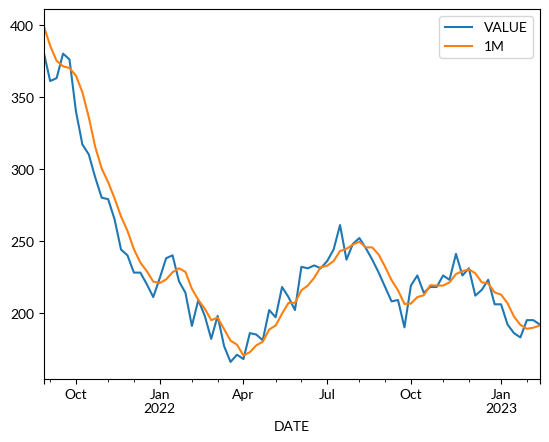

In [21]:
data.iloc[-78:].plot()

### VIX (SP500 volatility)

In [22]:
VIX = ('https://cdn.cboe.com/api/global/us_indices/daily_prices/'+
       'VIX_History.csv')
curr = pd.read_csv(VIX, index_col='DATE', parse_dates=True)
prmo = curr.resample('MS').mean().iloc[:-1]
prmo.index = prmo.index + pd.DateOffset(days=14)
df = pd.concat([prmo, curr.iloc[-1].to_frame().T]).CLOSE
df.to_csv(data_dir / 'vix.csv', index_label='date', header='True')
color = 'violet'
node = end_node(df, color, date='d', offset=0.35, full_year=True)
write_txt(text_dir / 'vix_node.txt', node)

ldate = dtxt(df.index[-1])['day1']
vallt = df.iloc[-1]
val3y = df.iloc[-37:].mean()
valmed = curr.CLOSE.median()

compare = compare_text(vallt, val3y, [3, 12, 30])
comp2 = compare_text(vallt, valmed, [3, 12, 30])

one_wk = (value_text(curr.CLOSE.diff(5).iloc[-1], 
                     style='increase_by', ptype='pp')
          .replace('percentage ', ''))

text = ('When investors are uncertain about the future, they will pay a '+
        'premium for the insurance-like qualities of options. The CBOE '+
        'volatility index, popularly known as the VIX, captures overall '+
        'changes in options prices to identify the market-implied volatility '+
        'in the S\&P 500 index over the following 30 days.\n\n'+
        f'The latest value for the VIX is {vallt:.1f} on {ldate} '+
        f'{c_line(color)}, {compare} the average index value of {val3y:.1f} '+
        f'over the past three years, and {comp2} the typical index value of '+
        f'{valmed:.1f} since 1990. The VIX {one_wk} over the past week.')
write_txt(text_dir / 'vixbasic.txt', text)
print(text)

When investors are uncertain about the future, they will pay a premium for the insurance-like qualities of options. The CBOE volatility index, popularly known as the VIX, captures overall changes in options prices to identify the market-implied volatility in the S\&P 500 index over the following 30 days.

The latest value for the VIX is 21.1 on February 23, 2023 (see {\color{violet}\textbf{---}}), slightly below the average index value of 24.9 over the past three years, and slightly above the typical index value of 17.9 since 1990. The VIX increased by one point over the past week.


### Inflation Expectations

In [23]:
data1 = fred_df('T5YIE').loc['2015':,'VALUE']
data1.to_csv(data_dir / 'infbreak.csv', index_label='date', 
             header=True)
data2 = fred_df('T5YIFR').loc['2015':,'VALUE']
df = pd.DataFrame({'5_year_breakeven': data1, 
                   '5_year_5_year_forward': data2})
df.to_csv(data_dir / 'infbreak_comb.csv', index_label='date')

color = 'blue!70!black'

node = end_node(data1, color, percent=True)
write_txt(text_dir / 'infbreak_node.txt', node)

ldatem = dtxt(data1.index[-1])['day1']
lvalm = data1.iloc[-1]
pdatem = dtxt(data1.dropna().index[-252])['day1']
pvalm = data1.dropna().iloc[-252]
p5valm = data1.dropna().iloc[-(252*5)]

text = (f'As of {ldatem}, markets expect an average inflation '+
        f'rate of {lvalm:.1f} percent over the next five ' + 
        f'years {c_line(color)}, compared to an expected rate '+
        f'of {pvalm:.1f} percent on {pdatem}. Markets had expected '+
        f'inflation to average {p5valm:.1f} percent per year over '+
        f'the past five years, five years ago.')
write_txt(text_dir / 'inf_exp_mkts.txt', text)
print(text)

p55val = data2.iloc[-1]
if data2.iloc[-1] + 0.1 > data1.iloc[-1]:
    compare = 'fall below '
elif data2.iloc[-1] - 0.1 < data1.iloc[-1]:
    compare = 'exceed '
else:
    compare = 'maintain the same rate as '
text = (f'Over this five-year period, markets suggest {p55val:.1f} '+
        f'percent inflation per year. Inflation rates in the near-term '+
        f'are therefore expected to {compare}inflation rates in the '+
        'longer-term.')
write_txt(text_dir / 'inf_exp_mkts_55.txt', text)
print(text)

As of February 23, 2023, markets expect an average inflation rate of 2.5 percent over the next five years (see {\color{blue!70!black}\textbf{---}}), compared to an expected rate of 2.9 percent on February 18, 2022. Markets had expected inflation to average 1.9 percent per year over the past five years, five years ago.
Over this five-year period, markets suggest 2.3 percent inflation per year. Inflation rates in the near-term are therefore expected to exceed inflation rates in the longer-term.


### High Yield Corporate Bond

In [24]:
df = fred_df('BAMLH0A0HYM2EY')
prmo = df.resample('MS').mean().iloc[:-1]
prmo.index = prmo.index + pd.DateOffset(days=14)
lt = df.iloc[-1].to_frame().T
data = pd.concat([prmo, lt])
data = data[~data.index.duplicated(keep='last')]
data.to_csv(data_dir / 'highyield.csv', index_label='date')
color = 'red!50!purple'

node = end_node(data['VALUE'], color, percent=True, date='d', full_year=True)
write_txt(text_dir / 'highyield_node.txt', node)

ltdt = dtxt(df.index[-1])['day1']
ltval = data.VALUE.iloc[-1]
mm = -2 if df.index[-1].is_month_start == True else -3
prmoval = data.VALUE.iloc[mm]
prmo = dtxt(data.index[mm])['mon1']
val19 = data.loc['2019', 'VALUE'].mean()

text = (f'As of {ltdt}, the effective yield for \\textbf{{high-yield '+
        f'corporate bonds}} in the index is {ltval:.1f} percent '+
        f'{c_line(color)}. In {prmo}, the average effective yield was '+
        f'{prmoval:.1f} percent. Prior to the COVID-19 pandemic, '+
        f'in 2019, the average effective yield was {val19:.1f} '+
        'percent. ')
write_txt(text_dir / 'highyield.txt', text)
print(text)

As of February 23, 2023, the effective yield for \textbf{high-yield corporate bonds} in the index is 8.5 percent (see {\color{red!50!purple}\textbf{---}}). In December 2022, the average effective yield was 8.5 percent. Prior to the COVID-19 pandemic, in 2019, the average effective yield was 6.1 percent. 


### Corporate Bonds Total Returns Index

In [25]:
#df = fred_df('BAMLCC0A0CMTRIV')
#data = df.dropna().resample('MS').mean().append(df.iloc[-1])
#data = data[~data.index.duplicated(keep='last')]
#data.to_csv(data_dir / 'corpbond_tri.csv', index_label='date')
#color = 'violet!80!blue'

#node = end_node(data['VALUE'], color, percent=True, date='d', full_year=True)
#write_txt(text_dir / 'cbtri_node.txt', node)

### Interest Rates Decomposition

In [26]:
url = ('https://www.clevelandfed.org/-/media/files/webcharts/inflationexpectations/'+
       'inflation-expectations.xlsx?sc_lang=en')
df = pd.read_excel(url, sheet_name='Expected Inflation', index_col=0, 
                   parse_dates=True)
df.columns = df.columns.str.replace('Expected Inflation', '').str.strip()
df.to_csv(data_dir / 'exp_infl_raw.csv', index_label='date')

df = pd.read_excel(url, sheet_name='Real Interest Rate', index_col=0, 
                   parse_dates=True)
df.columns = df.columns.str.strip()
df.to_csv(data_dir / 'frbcle_real_yield.csv', index_label='date')

In [27]:
df = pd.read_csv(data_dir / 'exp_infl_raw.csv', index_col='date', 
                  parse_dates=True) * 100
ltdt = dtxt(df.index[-1])['mon1']
write_txt(text_dir / 'frbcle_ry_date.txt', ltdt)
df2 = pd.read_csv(data_dir / 'treas_raw.csv', index_col='date', 
                  parse_dates=True).resample('MS').mean()
df2 = df2.loc[df.loc['1988':].index]
data, data2 = pd.DataFrame(), pd.DataFrame()
for dv in [3, 36]:
    for yr in [2, 5, 10]:
        ty = df2[f'{numbers2[yr].capitalize()}-year'].diff(dv).rename('Total')
        ie = df[f'{yr} year'].diff(dv).rename('IE')
        ry = (ty - ie).rename('RY')
        res = pd.DataFrame([ty, ie, ry]).T.iloc[-1]
        if dv == 3:
            data[f'{yr}-year'] = res
        else:
            data2[f'{yr}-year'] = res
tbl, tbl2 = data.T, data2.T
tbl.to_csv(data_dir / 'inf_exp_ch.csv', index_label='name')
tbl2.to_csv(data_dir / 'inf_exp_ch2.csv', index_label='name')
offset = 0.1
offset2 = 0.04
cols = ['IE', 'RY']
nodes = []
for col, row in itertools.product(cols, [0, 1, 2]):
    sdf = tbl[cols].iloc[row]
    i = tbl[col].iloc[row]
    j = (tbl['Total'] - tbl[col]).iloc[row]
    if ((i >= 0) & (j >= 0)): 
        h = ((sdf.cumsum() - (sdf / 2) + offset))
    elif ((i < 0) & (j < 0)):
        h = ((sdf.cumsum() - (sdf / 2) + offset2))
    else:
        h = (sdf / 2) + offset2
    v = h.to_dict()
    node = (f'\\absnode{{{row}.19}}{{{v[col]}}}'+
            f'{{\scriptsize {i:.2f}}}')
    nodes.append(node)
nodetext = '\n'.join(nodes)
write_txt(text_dir / 'inf_exp_ch_nodes.txt', nodetext)
nodes = []
for col, row in itertools.product(cols, [0, 1, 2]):
    sdf = tbl2[cols].iloc[row]
    i = tbl2[col].iloc[row]
    j = (tbl2['Total'] - tbl[col]).iloc[row]
    if ((i >= 0) & (j >= 0)): 
        h = ((sdf.cumsum() - (sdf / 2) + offset))
    elif ((i < 0) & (j < 0)):
        h = ((sdf.cumsum() - (sdf / 2) + offset2))
    else:
        h = (sdf / 2) + offset2
    v = h.to_dict()
    node = (f'\\absnode{{{row}.19}}{{{v[col]}}}'+
            f'{{\scriptsize {i:.2f}}}')
    nodes.append(node)
nodetext = '\n'.join(nodes)
write_txt(text_dir / 'inf_exp_ch_nodes2.txt', nodetext)

tx = pd.DataFrame({col: tbl[col].apply(lambda x: value_text(x, ptype='pp', 
                                                            digits=2, obj='plural',
                                                            threshold=0.01)) 
                   for col in tbl.columns})
tx2 = tx.loc['2-year']
tx10 = tx.loc['10-year']
tx_ = pd.DataFrame({col: tbl2[col].apply(lambda x: value_text(x, ptype='pp', 
                                                              digits=2, obj='plural', 
                                                              threshold=0.01)) 
                   for col in tbl2.columns})
tx_2 = tx_.loc['2-year']
tx_10 = tx_.loc['10-year']

text = (f'Over the three months ending {ltdt}, nominal two-year '+
        f'treasury yields {tx2.Total}, real yields {tx2.RY}, and '+
        f'inflation expectations {tx2.IE}. Ten-year treasury nominal '+
        f'yields {tx10.Total}, real yields {tx10.RY}, and inflation '+
        f'expectations {tx10.IE}.\n\nOver the three years ending {ltdt}, '+
        f'the nominal yield on two-year treasuries {tx_2.Total}, '+
        f'the real yield {tx_2.RY}, and inflation expectations {tx_2.IE}. '+
        f'For ten-year treasuries, the nominal yield {tx_10.Total}, '+
        f'the real yield {tx10.RY}, and expected inflation {tx_10.IE}.')
write_txt(text_dir / 'real_yield_model_ch.txt', text) 
print(text)

# Store change dates for chart
dt1 = dtxt(df.index[-4])['mon1']
dt2 = dtxt(df.index[-37])['mon1']
write_txt(text_dir / 'inf_exp_dt1.txt', dt1)
write_txt(text_dir / 'inf_exp_dt2.txt', dt2)

Over the three months ending February 2023, nominal two-year treasury yields decreased 0.03 percentage point, real yields increased 0.44 percentage point, and inflation expectations decreased 0.47 percentage point. Ten-year treasury nominal yields decreased 0.19 percentage point, real yields increased 0.17 percentage point, and inflation expectations decreased 0.36 percentage point.

Over the three years ending February 2023, the nominal yield on two-year treasuries increased 3.14 percentage points, the real yield increased 2.33 percentage points, and inflation expectations increased 0.81 percentage point. For ten-year treasuries, the nominal yield increased 2.20 percentage points, the real yield increased 0.17 percentage point, and expected inflation increased 0.47 percentage point.


### Real Interest Rates

In [28]:
df = pd.read_csv(data_dir / 'frbcle_real_yield.csv', index_col='date', 
                  parse_dates=True) * 100
clean_data = pd.read_csv(data_dir / 'fed_rates_raw.csv', 
                         index_col='date', parse_dates=True)

n = {'RIFLGFCY10_XII_N.B': 'Ten-year',
     'RIFLGFCY05_XII_N.B': 'Five-year'}

df3 = (clean_data[n.keys()].rename(n, axis=1)
       .dropna(subset=['Ten-year']))

data = pd.concat([df3.resample('MS').mean().iloc[:-1], 
                  df3.iloc[-1].to_frame().T], axis=0)

#res = (pd.concat([data['Ten-year'], df], axis=1)
#         .loc['1989':])
res = df.loc['1989':]
res.to_csv(data_dir / 'real_rates2.csv', index_label='date', 
            float_format='%g')

adj = node_adj(res)
smax = res.iloc[-1].idxmax()
adj[smax] = adj[smax] + 0.35

colors = {'Real Rate 10-year': 'blue', 
          'Real Rate 1-year': 'green!68!black'}
date = {series: 'm' if series == smax else None 
        for series in colors.keys()}
nodes  ='\n'.join([end_node(res[series], color, 
                            date=date[series], full_year=True, 
                            percent=True,
                            digits=2, offset=adj[series]) 
                   for series, color in colors.items()])
write_txt(text_dir / 'real_yield_nodes2.txt', nodes) 

ltdt = dtxt(res.index[-1])['mon1']
ltval = res["Real Rate 10-year"].iloc[-1]
val90 = res.loc['1990':'1999', 'Real Rate 10-year'].mean()
lt1 = res["Real Rate 1-year"].iloc[-1]
lt190 = res.loc['1990':'1999', 'Real Rate 1-year'].mean()
cl = c_line(colors["Real Rate 10-year"])
cl2 = c_line(colors["Real Rate 1-year"])
text = ('The model-based real yield on ten-year treasuries is '+
        f'{ltval:.2f} percent, as of {ltdt} {cl}. Ten-year '+
        f'treasury real yields averaged {val90:.2f} percent during '+
        'the 1990s. The model-based real yield for one-year '+
        f'treasuries is {lt1:.2f} percent in {ltdt}, compared '+
        f'to an average of {lt190:.2f} percent during the 1990s '+
        f'{cl2}. ')
write_txt(text_dir / 'real_yield_model.txt', text) 
print(text)

Three conflicting nodes
The model-based real yield on ten-year treasuries is 1.40 percent, as of February 2023 (see {\color{blue}\textbf{---}}). Ten-year treasury real yields averaged 3.30 percent during the 1990s. The model-based real yield for one-year treasuries is 1.58 percent in February 2023, compared to an average of 2.21 percent during the 1990s (see {\color{green!68!black}\textbf{---}}). 


In [29]:
clean_data = pd.read_csv(data_dir / 'fed_rates_raw.csv', 
                         index_col='date', parse_dates=True)

n = {'RIFLGFCY10_XII_N.B': 'Ten-year',
     'RIFLGFCY05_XII_N.B': 'Five-year'}

df = clean_data[n.keys()].rename(n, axis=1).dropna(subset=['Ten-year'])

data = pd.concat([df.resample('MS').mean().iloc[:-1], df.iloc[-1].to_frame().T])
data.to_csv(data_dir / 'real_rates.csv', index_label='date', 
            float_format='%g')

adj = node_adj(df)
smax = df.iloc[-1].idxmax()
adj[smax] = adj[smax] + 0.35

colors = {'Five-year': 'violet!50!blue!60!white', 'Ten-year': 'green!85!blue'}
date = {series: 'd' if series == smax else None 
        for series in colors.keys()}
nodes  ='\n'.join([end_node(df[series], color, 
                            date=date[series], full_year=True, 
                            digits=2, offset=adj[series]) 
                   for series, color in colors.items()])
write_txt(text_dir / 'real_yield_nodes.txt', nodes)  

ltdt = dtxt(df.index[-1])['day1']
prdt = (dtxt(df.index[-66])['day4'] if df.index[-66].year == df.index[-1].year 
          else dtxt(df.index[-66])['day1'])
ltval = df['Ten-year'].iloc[-1]
ltval5 = df['Five-year'].iloc[-1]
prval = df['Ten-year'].iloc[-66]
prval5 = df['Five-year'].iloc[-66]
cl = c_line(colors['Ten-year'])
cl2 = c_line(colors['Five-year'])
ch10 = value_text(df['Ten-year'].diff(252).iloc[-1], 'increase_by', 
                  ptype='pp', digits=2)
ch5 = value_text(df['Five-year'].diff(252).iloc[-1], 'increase_by', 
                  ptype='pp', digits=2)
text = ('One measure of real interest rates is treasury '+
        'inflation-indexed securities. The yield on these securities '+
        'can be a proxy for the interest rate investors would charge '+
        'for treasuries, without inflation. \n\n'+
        f'On {ltdt}, the real yield on ten-year treasuries was {ltval:.2f} '+
        f'percent {cl}, compared to {prval:.2f} percent three months prior, '+
        f'on {prdt}. Five-year treasuries yield {ltval5:.2f} percent in the '+
        f'latest data, and {prval5:.2f} percent three months prior, after '+
        f'adjusting for expected inflation {cl2}. ')
write_txt(text_dir / 'real_rates_basic.txt', text)
print(text)

One measure of real interest rates is treasury inflation-indexed securities. The yield on these securities can be a proxy for the interest rate investors would charge for treasuries, without inflation. 

On February 22, 2023, the real yield on ten-year treasuries was 1.52 percent (see {\color{green!85!blue}\textbf{---}}), compared to 1.38 percent three months prior, on November 16, 2022. Five-year treasuries yield 1.61 percent in the latest data, and 1.48 percent three months prior, after adjusting for expected inflation (see {\color{violet!50!blue!60!white}\textbf{---}}). 
